In [ ]:
import numpy as np
import scipy as sp
import pywt
import matplotlib.pyplot as plt

def cwt_spectrogram(x, fs, nNotes=12, nOctaves=np.inf, freq_range=(0, np.inf),
                    bandwidth=1.0, axis=-1, detrend=False, normalize=False):
    x = np.asarray(x)
    N = x.shape[axis]
    dt = 1 / fs
    times = np.arange(N) * dt
    ###########################################################################
    # detrend and normalize
    if detrend:
        x = sp.signal.detrend(x, axis=axis, type='linear')
    if normalize:
        x = x / x.std()
    ###########################################################################
    # Define some parameters of our wavelet analysis. 
    # range of scales (in time) that makes sense
    # min = 2 (Nyquist frequency)
    # max = np.floor(N/2)
    if nOctaves is None:
        nOctaves = np.inf
    nOctaves = min(nOctaves, np.log2(2 * np.floor(N / 2)))
    scales = 2 ** (1 + np.arange(np.floor(nOctaves * nNotes)) / nNotes)
    ###########################################################################
    # cwt and the frequencies used. 
    # Use the complex morelet with bw=2*bandwidth and center frequency of 1.0
    # bandwidth is the sigma of the gaussian envelope
    wavelet = 'cmor' + str(2 * bandwidth) + '-1.0'
    frequencies = pywt.scale2frequency(wavelet, scales) * fs
    scales = scales[(frequencies >= freq_range[0]) & (frequencies <= freq_range[1])]
    coef, frequencies = pywt.cwt(x, scales[::-1], wavelet=wavelet, sampling_period=dt, axis=axis)
    ###########################################################################
#     power = np.abs(coef)**2
    power = np.real(coef * np.conj(coef))
    # smooth a bit
#     power = sp.ndimage.gaussian_filter(power, sigma=2)
    ###########################################################################
    # cone of influence in frequency for cmorxx-1.0 wavelet
    f0 = 2 * np.pi
    cmor_coi = 2 ** -0.5
    cmor_flambda = 4 * np.pi / (f0 + (2 + f0 ** 2) ** 0.5)
    # cone of influence in terms of wavelength
    coi = N / 2 - np.abs(np.arange(N) - (N - 1) / 2)
    coi *= cmor_flambda * cmor_coi * dt
    # cone of influence in terms of frequency
    coif = 1 / coi
    return power, times, frequencies, coif

def spectrogram_plot(z, times, frequencies, coif, cmap='viridis', ax=None, colorbar=True):
    # create the figure if needed
    if ax is None:
        _, ax = plt.subplots()
    if isinstance(cmap, str):
        cmap = plt.get_cmap(cmap)

    pcm = ax.pcolormesh(times, frequencies, z, cmap=cmap, shading='gouraud')
    ax.plot(times, coif)
    ax.fill_between(times, coif, step='mid', alpha=0.2)
    plt.colorbar(mappable=pcm, ax=ax)
    ax.set_xlim(times.min(), times.max())
    ax.set_ylim(frequencies.min(), frequencies.max())
    ax.set_xlabel('Time (sec)')
    ax.set_ylabel('Frequency (Hz)')
    return ax

In [2]:
# Example signal
t = np.linspace(-1, 1, 200, endpoint=False)
sig  = np.cos(2 * np.pi * 7 * t) + sp.signal.gausspulse(t - 0.4, fc=2)
widths = np.arange(1, 31)
fs = 1 / (t[1] - t[0])

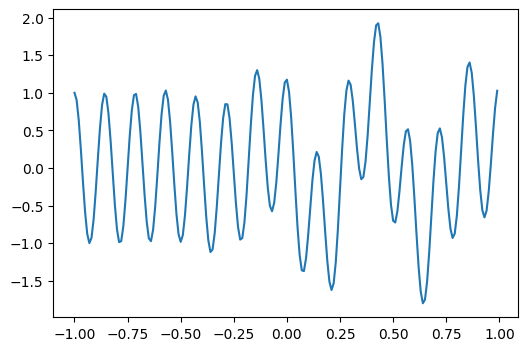

In [3]:
plt.figure(figsize=(6, 4))
plt.plot(t, sig)
plt.show()

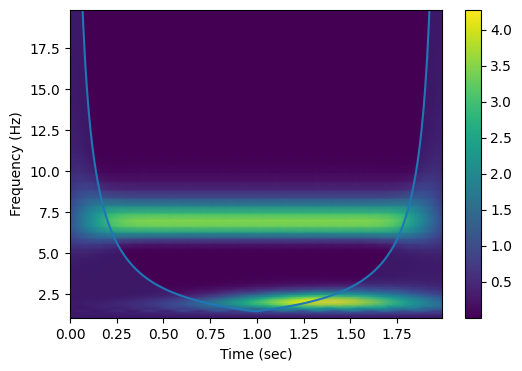

In [4]:
power, times, frequencies, coif = cwt_spectrogram(sig, fs, freq_range=(1., 20.))

_, ax = plt.subplots(figsize=(6, 4))
spectrogram_plot(power, times, frequencies, coif, ax=ax)
plt.show()

wavelet = pywt.ContinuousWavelet('cmor' + str(2.0) + '_1.0')

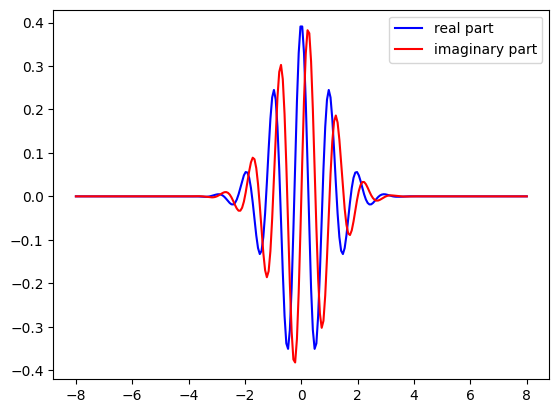

In [6]:
# Plot wavelet
phi, psi = wavelet.wavefun(level=8)
plt.plot(psi, phi.real, 'b', label='real part')
plt.plot(psi, phi.imag, 'r', label='imaginary part')
plt.legend()
plt.show()